In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from variational_method.method import method
import variational_method.metrics as metrics

In [2]:
def super_gauss(x, y, a, N):
    """
    Супергаусс на сетке x,y с параметрами a, N
    :param x: сетка по x
    :param y: сетка по y
    :param a: параметр, отвечает за размер области, которую срезает супергаусс
    :param N: отвечает за "крутизну" супергаусс, чем больше, тем быстрее функция стремится к 0
    :return: 2d array
    """
    return np.exp(-((x**2 + y**2) / a**2) ** N)


def mse(orig, restored):
    return np.linalg.norm(orig - restored) / np.sqrt(np.prod(restored.shape))


def normalize(front):
    """
    Нормирует исходный волновой фронт на квадрат [-1, 1] x [-1, 1]
    :param front: волновой фронт
    :return: отнормированный волновой фронт
    """
    tmp = front
    tmp -= tmp.min()
    tmp /= tmp.max()
    return tmp


def get_mask(x, y, r):
    return 1 *(x**2 + y**2 < r**2)


def cernike_front(x, y, func):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(x, y)
    return func(rho, phi)


def d_rho_dx(x, y):
    return x / np.sqrt(x**2 + y**2)


def d_rho_dy(x, y):
    return y / np.sqrt(x**2 + y**2)


def d_phi_dx(x, y):
    return 1 / (y * (1 + (x / y)**2))


def d_phi_dy(x, y):
    return - x / (y**2 * (1 + (x / y)**2))


def get_hole(x, y, r):
    return get_mask(x, y, r) ^ 1

In [76]:
U_n = 512
a = 1
grid_x, grid_y = np.mgrid[-a:a:1j*U_n, -a:a:1j*U_n]
U_h = 2 * a / U_n
rho = np.sqrt(grid_x**2 + grid_y**2)
phi = np.arctan2(grid_x, grid_y)
cernikes = dict()
#R_2^2
cernikes['r^2'] = lambda x, y: x**2 + y**2 - 1
cernikes["r^2'x"] = lambda x, y: 2 * x
cernikes["r^2'y"] = lambda x, y: 2 * y
#z_2^2
cernikes["r^2cos(2phi)"] = lambda x, y: cernike_front(x, y, lambda rho, phi: rho**2 * np.cos(2 * phi))
cernikes["r^2cos(2phi)'x"] = lambda x, y: 2 * rho * d_rho_dx(x, y) * np.cos(2 * phi) + rho**2 * (-np.sin(2 * phi)) * 2 * d_phi_dx(x, y)
cernikes["r^2cos(2phi)'y"] = lambda x, y: 2 * rho * d_rho_dy(x, y) * np.cos(2 * phi) + rho**2 * (-np.sin(2 * phi)) * 2 * d_phi_dy(x, y)

#z_3^3
cernikes["r^3cos(3phi)"] = lambda x, y: cernike_front(x, y, lambda rho, phi: rho**3 * np.cos(3 * phi))
cernikes["r^3cos(3phi)'x"] = lambda x, y: 3 * rho**2 * d_rho_dx(x, y) * np.cos(3 * phi) + rho**3 * 3 * (-np.sin(3 * phi)) * d_phi_dx(x, y)
cernikes["r^3cos(3phi)'y"] = lambda x, y: 3 * rho**2 * d_rho_dy(x, y) * np.cos(3 * phi) + rho**3 * 3 * (-np.sin(3 * phi)) * d_phi_dy(x, y)

#z_5^5
cernikes["r^5cos(5phi)"] = lambda x, y: cernike_front(x, y, lambda rho, phi: rho**5 * np.cos(5 * phi))
cernikes["r^5cos(5phi)'x"] = lambda x, y: 5 * rho**4 * d_rho_dx(x, y) * np.cos(5 * phi) + rho**5 * 5 * (-np.sin(5 * phi)) * d_phi_dx(x, y)
cernikes["r^5cos(5phi)'y"] = lambda x, y: 5 * rho**4 * d_rho_dy(x, y) * np.cos(5 * phi) + rho**5 * 5 * (-np.sin(5 * phi)) * d_phi_dy(x, y)

#z_1^1
cernikes["r^1cos(phi)"] = lambda x, y: cernike_front(x, y, lambda rho, phi: rho * np.cos(phi))
cernikes["r^1cos(phi)'x"] = lambda x, y: d_rho_dx(x, y) * np.cos(phi) + rho * (-np.sin(phi)) * d_phi_dx(x, y)
cernikes["r^1cos(phi)'y"] = lambda x, y: d_rho_dy(x, y) * np.cos(phi) + rho * (-np.sin(phi)) * d_phi_dy(x, y)

#z_6^6
cernikes["r^6cos(6phi)"] = lambda x, y: cernike_front(x, y, lambda rho, phi: rho**6 * np.cos(6 * phi))
cernikes["r^6cos(6phi)'x"] = lambda x, y: 6 * rho**5 * d_rho_dx(x, y) * np.cos(6 * phi) + rho**6 * 6 * (-np.sin(6 * phi)) * d_phi_dx(x, y)
cernikes["r^6cos(6phi)'y"] = lambda x, y: 6 * rho**5 * d_rho_dy(x, y) * np.cos(6 * phi) + rho**6 * 6 * (-np.sin(6 * phi)) * d_phi_dy(x, y)

cernike_line = "r^3cos(3phi)"
cernike_g1_line = cernike_line + "'x"
cernike_g2_line = cernike_line + "'y"
gauss_rads = np.linspace(a/2, a, 10)

s_gausses = dict()
N = 5
for r in gauss_rads:
    s_gausses[r] = super_gauss(grid_x, grid_y, r, N)
print(gauss_rads)

[0.5        0.55555556 0.61111111 0.66666667 0.72222222 0.77777778
 0.83333333 0.88888889 0.94444444 1.        ]


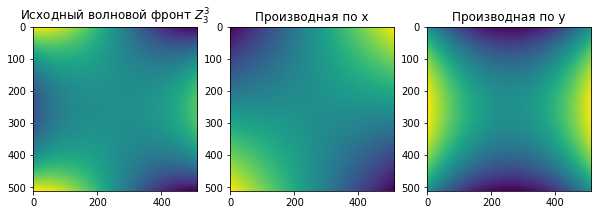

In [78]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
ax[0].imshow(cernikes[cernike_line](grid_x, grid_y))
ax[1].imshow(cernikes[cernike_g1_line](grid_x, grid_y))
ax[2].imshow(cernikes[cernike_g2_line](grid_x, grid_y))
ax[0].set_title('Исходный волновой фронт $Z_3^3$')
ax[1].set_title('Производная по x')
ax[2].set_title('Производная по y')

fig.savefig('../tex/' + cernike_line)

In [67]:
cernikes_gauss = dict()
for i, r in enumerate(gauss_rads):
    cernikes_gauss[r] = normalize(cernikes[cernike_line](grid_x, grid_y) * s_gausses[r])

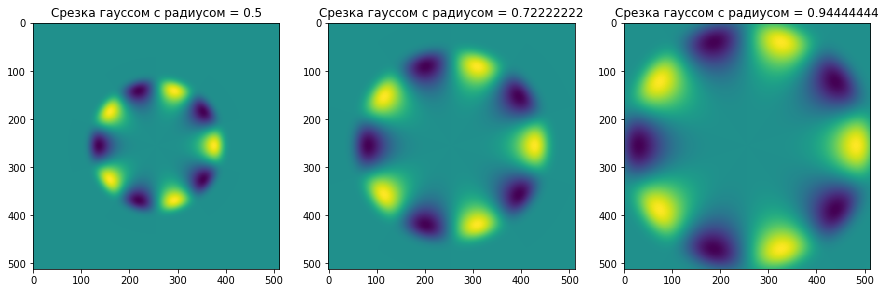

In [68]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i, r in enumerate([gauss_rads[0], gauss_rads[4], gauss_rads[8]]):
    ax[i].imshow(cernikes_gauss[r])
    ax[i].set_title('Срезка гауссом с радиусом = ' + str(r)[0:10])

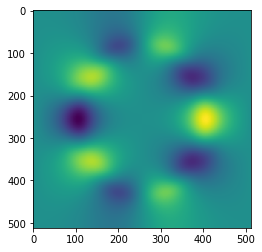

In [69]:
res = method(cernikes[cernike_g1_line](grid_x, grid_y) * s_gausses[gauss_rads[3]],
                                cernikes[cernike_g2_line](grid_x, grid_y) * s_gausses[gauss_rads[1]],
                               U_h, U_h, alpha=1e-3, gamma=0.0028, s=0.842, l = a)
plt.imshow(res)

In [70]:
restored_fronts = dict()
for r in gauss_rads:
    restored_fronts[r] = method(cernikes[cernike_g1_line](grid_x, grid_y) * s_gausses[r],
                                cernikes[cernike_g2_line](grid_x, grid_y) * s_gausses[r],
                               U_h, U_h, alpha=1e-3, gamma=0.0028, s=0.842, l = a)
    restored_fronts[r] = normalize(restored_fronts[r])

In [71]:
C, L2 = [], []
for i, r in enumerate(gauss_rads):
    mask = get_mask(grid_x, grid_y, r * 0.4)
    front = cernikes[cernike_line](grid_x, grid_y)
    orig = normalize(normalize(front) * mask)
    restored = normalize(restored_fronts[r] * mask)
    C.append(metrics.C(orig, restored))
    print("C (r = " + str(r) + ")",  C[i])
    
    L2.append(metrics.L2(orig, restored))
    print("L2 (r = " + str(r) + ")",  L2[i])
    print("-" * 100)

C (r = 0.5) 0.04558139552659035
L2 (r = 0.5) 0.023788855540794573
----------------------------------------------------------------------------------------------------
C (r = 0.5555555555555556) 0.043572102448519945
L2 (r = 0.5555555555555556) 0.022689459169348287
----------------------------------------------------------------------------------------------------
C (r = 0.6111111111111112) 0.038804890218028354
L2 (r = 0.6111111111111112) 0.020279206922347918
----------------------------------------------------------------------------------------------------
C (r = 0.6666666666666666) 0.03710565938980548
L2 (r = 0.6666666666666666) 0.019380718542174942
----------------------------------------------------------------------------------------------------
C (r = 0.7222222222222222) 0.03863770000836275
L2 (r = 0.7222222222222222) 0.02005028690642882
----------------------------------------------------------------------------------------------------
C (r = 0.7777777777777778) 0.041171111760654

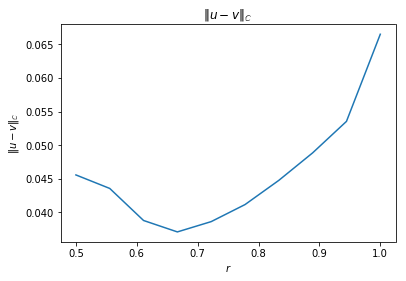

In [72]:
plt.plot(gauss_rads, C)
plt.title('$\Vert u - v \Vert_\mathbb{C}$')
plt.xlabel('$r$')
plt.ylabel('$ \Vert u - v \Vert_\mathbb{C} $')
plt.savefig('../tex/C_norm_' + cernike_line)

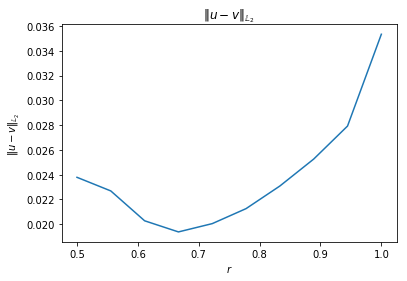

In [73]:
plt.plot(gauss_rads, L2)
plt.title('$\Vert u - v\Vert_{\mathbb{L}_2}$')
plt.xlabel('$r$')
plt.ylabel('$\Vert u - v\Vert_{\mathbb{L}_2}$')
plt.savefig('../tex/L_2_norm' + cernike_line)

0.00518838648767578


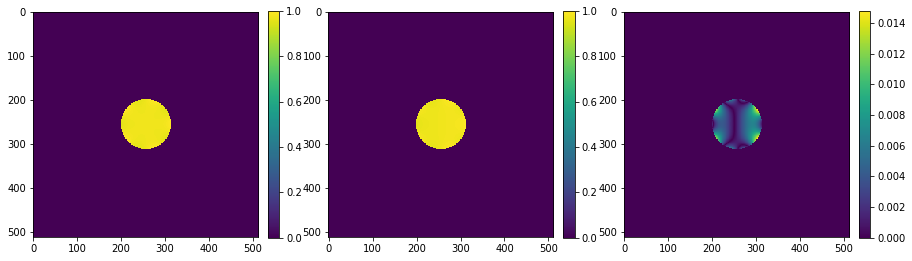

In [80]:
fig, ax = plt.subplots(1,3, figsize = (15, 15))
gauss_num = 1
front = cernikes_gauss[gauss_rads[gauss_num]]

mask = get_mask(grid_x, grid_y, gauss_rads[gauss_num] * 0.4)

orig = normalize(normalize(front) * mask)
restored = normalize(restored_fronts[gauss_rads[gauss_num]] * mask)
im1 = ax[0].imshow(orig)
im2 = ax[1].imshow(restored)
im3 = ax[2].imshow(np.abs(orig - restored))
fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)

print(metrics.L2(orig, restored))

#plt.savefig('')